#  New data generator

Scheme:

Quickly modify the mel dataloader - so that you can poitn it at a given folder (not just the data folder)

User generated or random choice of number of negative and positive words in 1 sample  (between 0 and 1) - want an even split between 01, 10 and 11 but no 00

Each clip is 1 second or less - so can have a max of I'd say 8 - to leave 2 second of background

Select the [1 to 2] clips - and get their sizes in tensor format 

Generate the random non overlapping positiions of the words - this might be tricky as we need to put them in places where there is still space 


Generate the dataspace

In [109]:
import torch
import random
from random import choice, seed
import numpy as np

import torchaudio
import glob



#now functionalise the below 


# test new class

In [236]:
class Create_Test_Train_Data_multiple_recs():
    
    def __init__(self, background_filepath, sample_time,resample_rate,number_samples, folder_trigger_word,folder_negative_word,outpath_location):
        '''
        background_filepath - location of the .wave file containg the background noise
        sample_time - length of the entire clip - default 10 sec - needs to be greater than length of the negative/trigger word
        resample_rate - the number of samples persecond to reduce the data set to
        number_samples - the numberf of clips containing the trigger word - there will be an equal number not containing the trigger word
        folder_trigger_word -  folder containing the examples of the trigger word
        folder_negative_word - folder containing the negative word - for now I'm only using 1 word - could improve to have multiple words 
        outpath_location - location to save the training/test data sets
        '''
        self.background_filepath = background_filepath
        self.sample_time = sample_time
        self.resample_rate = resample_rate
        self.number_samples = number_samples
        self.folder_trigger_word = folder_trigger_word
        self.folder_negative_word = folder_negative_word
        self.outpath_location = outpath_location
        self.test_train_split = 0.7
    
    #create a resample 
    
    
    def resample(self,sample_rate,new_sample_rate,waveform):
        transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
        transformed_waveform = transform(waveform)
        return transformed_waveform

        
    
    
    def create_background(self):
        #first load in background file
        b_waveform, b_sample_rate = torchaudio.load(self.background_filepath)
        
        #adjust length of background file - to extract the first self.sample_time seconds
        units = int(b_sample_rate * self.sample_time)
        b_waveform_t = b_waveform[0,0:units].reshape([1,units])
        
        b_waveform_t_resample = self.resample(b_sample_rate,self.resample_rate,b_waveform_t)
        
        return b_waveform_t_resample
    
    
    def generate_filepaths(self,filepath):
        temp = glob.glob(filepath + '*.wav')
        
        temp2 = temp[:self.number_samples]
        
        return temp2
    
    def create_labels_list(self,label_random, bool_tw,start, end, background_length):
        ''' create label for the given data set'''
          

    
        if bool_tw==False:
            return label_random
        else: 
            #add in the ones where the audio occurs 
            label_random[0,start:end] = torch.ones([1,end-start])
            return label_random    
    
  

    def generate_clip_ranges(self,clip_lengths,Lb):
        '''
        clip_lengths - list containing the index lenght of the N clips
        Lb - length of the background - torch tensor of shape [1,Lb]

        #essentially the sum of all the deltas and sum of all the lengths of the clips must be less than the total length of the background
        # we already know the lengths
        # so below we randomly generate N-1 of the deltas (choosing values in the range (1,int(length background / (number of clips + 1)) so we can satisfy 
        # the necessary condition for this algorithm to work 
        # additionally we want a non zero delta hence we start the range at 1
        # the final delta is generated by subtracting   L background - sum(lengths) - sum(N-1 deltas) - giving a consistent answer 

        '''
        if Lb < sum(clip_lengths) +5:
            print('background too small to fit clips')
            return

        Nclips = len(clip_lengths)

        # remaining free space to use as padding around the clips
        rem = Lb - sum(clip_lengths)

        #initialise the delta variable 
        delta = [0] *Nclips

        #create the N-1 delta values
        for I in range(Nclips-1):
            delta[I] = choice([i for i in range(1,int(Lb/(Nclips+1)))])

        #calculate the final delta so that the clips can't overlap
        #so we don't gen any overlap - note its an inequality hence the use of random choice again 
        max_delta =  rem - sum(delta) 
        if max_delta == 1:
            delta[-1] = 1
        else:
            delta[-1] = choice([i for i in range(1, max_delta)])

        #print(delta)

        #now generate ranges
        start = 0
        end = 0
        clip_locs = [0]*Nclips
        for I in range(Nclips):
            a = delta[0:I+1]
            b = clip_lengths[0:I]
            start = sum(a) + sum(b)
            end = start +clip_lengths[I]
            clip_locs[I] = range(start,end)

        return delta, clip_locs     
    
    
    
    
    
    def generate_sample_list(self,bool_tw_list,background,filepath_list):

        
        # add word in a rondom place
        background_length = background.shape[1]
        print(f'background shape {background_length}')
     
        
        N_lists = len(filepath_list)
        
        clip_lengths = [0]*N_lists
        
        #generate ranges by first generating sizes of clip lengths        
        for I in range(N_lists):
            filepath = filepath_list[I]
            waveform, sample_rate = torchaudio.load(filepath)
            clip_lengths[I] = waveform.shape[1]
        print(f'clip_lengths ={clip_lengths}')
        print(background_length)
        (d,clip_ranges) = self.generate_clip_ranges(clip_lengths,Lb = background_length)
        
        
        
        waveform_padded_random = background
        #create labels 
        label= torch.zeros([1,background_length])
        
        for I in range(N_lists):
            filepath = filepath_list[I]
            bool_tw = bool_tw_list[I]
            # load audio  
            waveform, sample_rate = torchaudio.load(filepath)
            #resample 
            waveform_resample = self.resample(sample_rate,self.resample_rate,waveform)

            #Create location to insert waveform into background





            start = clip_ranges[I][0]
            end = clip_ranges[I][-1] +1
            print(f'(start/end {start}/{end}')

            print(f"inserted clip into {start} position - {start/self.resample_rate} seconds out of {self.sample_time} seconds")





            # print(waveform_resample.shape)
            # print(background.shape)
            # print(waveform_padded_random.shape)
            waveform_padded_random[0,start:end]  = waveform_resample + waveform_padded_random[0,start:end]

            # finally create label
            label = self.create_labels_list(label,bool_tw,start, end, background_length)   

        return waveform_padded_random, label
        
    
    
    

        
        
    def generate_all(self):
        positive_filepaths = self.generate_filepaths(self.folder_trigger_word)
        negative_filepaths = self.generate_filepaths(self.folder_negative_word)
        
        train_outfile = self.outpath_location + '/train/'
        test_outfile = self.outpath_location + '/test/'
        
        train_I = int(np.ceil(self.test_train_split * self.number_samples ))

        #need to geneate background each loop - some how it was getting overwritten
        
        #geneate positive lables 
        bool_tw = True
        for I in range(self.number_samples):
            background = self.create_background()
            positive_sample,label = self.generate_sample(bool_tw,background,positive_filepaths[I])
            name= f'data_positive_{I}.wav'
            label_name = f'label_positive_{I}.pt'


            if I < train_I:
                path = train_outfile+name
                path_label = train_outfile+label_name

            else:
                path = test_outfile+name
                path_label = test_outfile+label_name

            #save result
            print(path)
            print(path_label)
            torchaudio.save(path,positive_sample,self.resample_rate)  
            torch.save(label,path_label)
            
        #generate negative labels
        bool_tw = False
        for I in range(self.number_samples):
            background = self.create_background()
            negative_sample,label = self.generate_sample(bool_tw,background,negative_filepaths[I])
            name= f'data_negative_{I}.wav'
            label_name = f'label_negative_{I}.pt'


            if I < train_I:
                path = train_outfile+name
                path_label = train_outfile+label_name

            else:
                path = test_outfile+name
                path_label = test_outfile+label_name

            #save result
            print(path)
            print(path_label)
            torchaudio.save(path,negative_sample,self.resample_rate)  
            torch.save(label,path_label)        
        
        return positive_sample, negative_sample, 
    


 # test new class

In [237]:
# run the class     

# nine folder > 3k files
# backward folder > 1.5k files

    
background_filepath =  'speech_commands_v0.02.tar/_background_noise_/doing_the_dishes.wav'
sample_time = 10
resample_rate = 16000 #think I want to change this to 16k - the original rate
number_samples = 10
folder_trigger_word = 'speech_commands_v0.02.tar/nine/'
folder_negative_word = 'speech_commands_v0.02.tar/backward/'
outpath_location = 'data_multiple_clips'

val = Create_Test_Train_Data_multiple_recs(background_filepath, sample_time,resample_rate,number_samples, folder_trigger_word,folder_negative_word,outpath_location)





In [253]:
filepath_list = val.generate_filepaths(val.folder_trigger_word)[0:3]
filepath_list_neg = val.generate_filepaths(val.folder_negative_word)[0]
filepath_list.append(filepath_list_neg) 
bool_tw_list = [True] * 4
bool_tw_list[-1] = False

background = val.create_background()

In [254]:
filepath_list

['speech_commands_v0.02.tar/nine\\00b01445_nohash_0.wav',
 'speech_commands_v0.02.tar/nine\\012c8314_nohash_0.wav',
 'speech_commands_v0.02.tar/nine\\012c8314_nohash_1.wav',
 'speech_commands_v0.02.tar/backward\\0165e0e8_nohash_0.wav']

In [255]:
val.generate_clip_ranges([16000, 16000, 16000],Lb = 160000)

([22542, 3038, 193],
 [range(22542, 38542), range(41580, 57580), range(57773, 73773)])

In [256]:
wav,label_out = val.generate_sample_list(bool_tw_list,background,filepath_list)

from IPython.display import Audio
Audio(wav.numpy()[0], rate=16000,autoplay=True )
    


background shape 160000
clip_lengths =[16000, 16000, 16000, 16000]
160000
(start/end 23035/39035
inserted clip into 23035 position - 1.4396875 seconds out of 10 seconds
(start/end 69447/85447
inserted clip into 69447 position - 4.3404375 seconds out of 10 seconds
(start/end 107977/123977
inserted clip into 107977 position - 6.7485625 seconds out of 10 seconds
(start/end 131221/147221
inserted clip into 131221 position - 8.2013125 seconds out of 10 seconds


C:\Users\AT030915\AIG\venv\AIG_venv\lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (151) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Return Spectrogram of shape torch.Size([1, 151, 801])


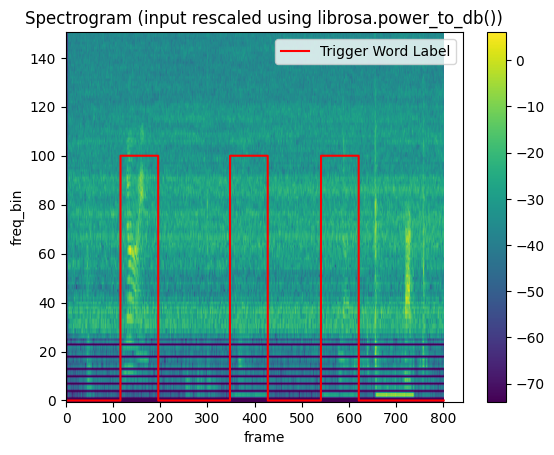

In [257]:
#visualise as spectrogram
import torchaudio.transforms as T
from data_loading import plot_spectrogram
def apply_spectrogram(padded_waveform,number_frequencies = 151, number_time_steps = 400, sample_rate = 16000):
    '''
    Number frequency and time step - derived from those used in the original model createion
    '''
    

    spectrogram =  T.MelSpectrogram(sample_rate,
                                    n_fft=number_time_steps,
                                    n_mels = number_frequencies,
                                    normalized = True)

    spec = spectrogram(padded_waveform)

    print(f'Return Spectrogram of shape {spec.shape}')
    
    return spec

padded_spec = apply_spectrogram(wav)



plot_spectrogram(padded_spec[0],label_out.detach().numpy(), title=None, ylabel='freq_bin', aspect='auto', xmax=None)



In [6]:

#start with array of size 10 secs at 
time = 1
rsr = 14

waveform = torch.zeros([1,time*rsr])
Lb = waveform.shape[1] #length background

clip_lengths = [3,2,4]
Nclips = len(clip_lengths)


print(waveform)


tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [108]:
# want to be able to choose percentages that are each combination
N_neg = 100
N_pos = 100

max_chunk = 1

#schema for pc_chunks [1n0p,0n1p,11,21,12,22]  #- 3! number
pc_chunks = [5,5,20,30,30,10]
sum(pc_chunks)

number


100

In [107]:
# need to create code that divides the number of positive and negative clips into chunks
N_neg = 100
N_pos = 100

max_chunk = 3
#keep this running total 
I_neg = 0
I_pos = 0

while (I_neg < N_neg and I_pos < N_pos):

    chunk_pos = choice([i for i in range(1,max_chunk)])
    chunk_neg = choice([i for i in range(1,max_chunk)])

    I_pos += chunk_pos
    I_neg += chunk_neg

print(chunk_pos,chunk_neg,I_neg,I_pos)

2 2 101 100


In [92]:
def generate_clip_ranges(clip_lengths,Lb):
    '''
    clip_lengths - list containing the index lenght of the N clips
    Lb - length of the background - torch tensor of shape [1,Lb]
    
    #essentially the sum of all the deltas and sum of all the lengths of the clips must be less than the total length of the background
    # we already know the lengths
    # so below we randomly generate N-1 of the deltas (choosing values in the range (1,int(length background / (number of clips + 1)) so we can satisfy 
    # the necessary condition for this algorithm to work 
    # additionally we want a non zero delta hence we start the range at 1
    # the final delta is generated by subtracting   L background - sum(lengths) - sum(N-1 deltas) - giving a consistent answer 

    '''
    if Lb < sum(clip_lengths) +5:
        print('background too small to fit clips')
        return
    
    Nclips = len(clip_lengths)
    
    # remaining free space to use as padding around the clips
    rem = Lb - sum(clip_lengths)

    #initialise the delta variable 
    delta = [0] *Nclips

    #create the N-1 delta values
    for I in range(Nclips-1):
        delta[I] = choice([i for i in range(1,int(Lb/(Nclips+1)))])

    #calculate the final delta so that the clips can't overlap
    #so we don't gen any overlap - note its an inequality hence the use of random choice again 
    max_delta =  rem - sum(delta) 
    if max_delta == 1:
        delta[-1] = 1
    else:
        delta[-1] = choice([i for i in range(1, max_delta)])

    #print(delta)

    #now generate ranges
    start = 0
    end = 0
    clip_locs = [0]*Nclips
    for I in range(Nclips):
        a = delta[0:I+1]
        b = clip_lengths[0:I]
        start = sum(a) + sum(b)
        end = start +clip_lengths[I]
        clip_locs[I] = range(start,end)

    return delta, clip_locs    
    

In [64]:
generate_clip_ranges(clip_lengths,16)

([2, 3, 1], [range(2, 5), range(8, 10), range(11, 15)])

In [31]:

#essentially the sum of all the deltas and sum of all the length sof the clips must be less than the total length of the background
# we already know the lengths
# so below we randomly generate N-1 of the deltas (choosing values in the range (1,int(length background / (number of clips + 1)) so we can satisfy 
# additoinally we want a non zero delta hence we start the range at 1
# the necessary condition for this algorithm to work 
# the final delta is generated by subtracting   L background - sum(lengths) - sum(N-1 deltas) - giving a consistent answer 
rem = Lb - sum(clip_lengths)

delta = [0] *Nclips

for I in range(Nclips-1):
    delta[I] = choice([i for i in range(1,int(Lb/(Nclips+1)))])

#calculate the final delta so that the clips can't overlap
#so we don't gen any overlap - note its an inequality hence the use of random choice again 
max_delta =  rem - sum(delta) 
if max_delta == 1:
    delta[-1] = 1
else:
    delta[-1] = choice([i for i in range(1, max_delta)])

print(delta)

#now generate ranges
start = 0
end = 0
clip_locs = [0]*Nclips
for I in range(Nclips):
    a = delta[0:I+1]
    b = clip_lengths[0:I]
    start = sum(a) + sum(b)
    end = start +clip_lengths[I]
    clip_locs[I] = range(start,end)
    
clip_locs    

[1, 1, 2]


[range(1, 4), range(5, 7), range(9, 13)]

In [50]:
a = clip_locs[2]

print(a[0],a[-1])

9 12


In [41]:
delta

[1, 1, 2]

In [42]:
for I in range(Nclips):
    
    a = delta[0:I+1]
    b = clip_lengths[0:I]
    print(a,b)
    start = sum(a) + sum(b)
    end = start +clip_lengths[I]
    print(start,end)

[1] []
1 4
[1, 1] [3]
5 7
[1, 1, 2] [3, 2]
9 13


In [43]:
sum(delta[0:-1])

2

In [276]:
start_ranges = [0]*Nclips
start_ranges

[0, 0, 0]

In [277]:
start_ranges = [0]*Nclips
start_ranges_adj = [0]*Nclips

for I in range(Nclips):
    start_ranges[I] = range(0,Lb-clip_lengths[I])
start_ranges    

[range(0, 29), range(0, 30), range(0, 28)]

In [278]:
for I in range(Nclips):
    start = choice(start_ranges[I])
    save_positions[I]= [start,start+clip_lengths[I]] 
    
save_positions

array([[ 5,  8],
       [14, 16],
       [22, 26]], dtype=int8)

In [253]:
start_ranges_adj[I]

[]

In [373]:
start_ranges = [[0]]*Nclips
start_ranges_adj = [[0]]*Nclips
save_positions = np.zeros([Nclips,2],dtype=np.int8)
save_positions_adj = np.zeros([Nclips],dtype=np.int8)


for I in range(Nclips):
    start_ranges[I] = range(0,Lb-clip_lengths[I])
    
    start_ranges_adj[I] = start_ranges[I]


    for J in range(Nclips-1):
        print(J)
        start = save_positions[J][0] - clip_spacing - clip_lengths[J+1]
        end = save_positions[J][1] + clip_spacing 
        start_ranges_adj[I] = [i for i in start_ranges_adj[I] if i not in range(start,end)]
    print([i for i in start_ranges_adj[I]])
        
    start = choice(start_ranges_adj[I])
    save_positions[I]= [start,start+clip_lengths[I]]     

for I in range(Nclips):
    print([i for i in range(save_positions[I][0],save_positions[I][1])])

0
1
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
0
1
[6, 7, 8, 9, 10, 11, 12, 13]
0
1
[]


IndexError: list index out of range

In [389]:
save_positions

array([[ 2,  5],
       [11, 13],
       [ 0,  0]], dtype=int8)

In [401]:
start_ranges_adj[I] = start_ranges[I]
for J in range(Nclips-1):
    print(J)
    start = save_positions[J][0] - clip_spacing - 3
    end = save_positions[J][1] + clip_spacing 
    #print([i for i in range(start,end)])
    print(start_ranges_adj[I])
    print( range(start,end))
    start_ranges_adj[I] = [i for i in start_ranges_adj[I] if i not in range(start,end)]
    
    print(start_ranges_adj[I])

0
range(0, 12)
range(-3, 6)
[6, 7, 8, 9, 10, 11]
1
[6, 7, 8, 9, 10, 11]
range(6, 14)
[]


In [403]:
end

14

In [381]:
    for J in range(Nclips-1):
        print(J)
        start = max(save_positions[J][0] - clip_spacing - clip_lengths[J+1],0)
        end = min(save_positions[J][1] + clip_spacing ,Lb)
        print(start,end)
        start_ranges_adj[I] = [i for i in start_ranges_adj[I] if i not in range(start,end)]

0
0 6
1
6 14


In [386]:
for J in range(Nclips-1):
    print(J)
    start = save_positions[J][0] - clip_spacing - clip_lengths[J+1]
    end = save_positions[J][1] + clip_spacing 
    start_ranges_adj[I] = [i for i in start_ranges_adj[I] if i not in range(start,end)]
print([i for i in start_ranges_adj[I]])

0
1
[]


In [213]:
removal_inds= [[0]]*Nclips # initially blank
removal_inds_adj= [[0]]*Nclips # initially blank

for I in range(Nclips):
    print(I)

    
    #different start range for each clip as we have to offset the clip length form the end so it doesnt' over shoot
    start_ranges = range(0,Lb-clip_lengths[I])
    
    print('start ranges')
    print(start_ranges)
    
    
    allowed_ranges = start_ranges
    
    allowed_ranges = [i for i in start_ranges if i not in removal_inds_adj[I]]
    print('allowed_ranges')
    print(allowed_ranges)   

    
    start = choice(allowed_ranges)
    save_positions[I]= [start,start+clip_lengths[I]] 

    removal_inds[I] = range(save_positions[I][0],save_positions[I][1])

    if I < Nclips -1:
        removal_inds_adj[I] = range(save_positions[I][0]-clip_spacing-clip_lengths[I+1],save_positions[I][1]-clip_spacing)
  
    print('removal inds')
    print(removal_inds[I])
#     for J in range(0,I):
#         allowed_ranges = [i for i in start_ranges if i not in removal
    
#     #this will remove any existing clip positions from the 
#     allowed_ranges = [i for i in start_ranges if i not in removal_inds]
#     print('allowed_ranges')
#     print(allowed_ranges) 
    
    
#     start = choice(allowed_ranges)
#     save_positions[I]= [start,start+clip_lengths[I]] 
#     print('save_positions')
#     print(save_positions[I])
    
    
    

0
start ranges
range(0, 13)
allowed_ranges
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
removal inds
range(7, 10)
1
start ranges
range(0, 14)
allowed_ranges
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
removal inds
range(13, 15)
2
start ranges
range(0, 12)
allowed_ranges
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
removal inds
range(9, 13)


In [214]:
save_positions

array([[ 7, 10],
       [13, 15],
       [ 9, 13]], dtype=int8)

In [172]:
I =0
#random.seed(1)

#create list of possible positions for clip A
# note the range is [start_ranges[J]:start_ranges[J] + clip_lengths]
start_ranges = [i for i in range(0,Lb-max(clip_lengths))]
start_ranges

removal_inds= [] # initially blank


for I in range(Nclips):
    print(I)
    
    print('start ranges')
    print(start_ranges) 
    print('clip positions')
    
    
    start = choice(start_ranges)
    save_positions[I]= [start,start+clip_lengths[I]]    
    range_temp = range(save_positions[I][0],save_positions[I][1])
    print([i for i in range_temp])
    
    range_temp_clip = range(save_positions[I][0]-clip_spacing,save_positions[I][1]+clip_spacing)
          
    #need to update the save_positions 
    start_ranges = [i for i in start_ranges if i not in range_temp_clip]
    
    if I< Nclips-1:
        start_ranges = [i for i in start_ranges if i not in range(save_positions[I][0]-clip_lengths[I+1],save_positions[I][0])]
        
    print('')
    


0
start ranges
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
clip positions
[8, 9]

1
start ranges
[0, 1, 2, 3, 4, 11]
clip positions
[11, 12, 13]

2
start ranges
[0, 1, 2, 3, 4]
clip positions
[2, 3, 4, 5]



In [173]:
I =0
waveform[0,save_positions[I][0]:save_positions[I][1]] = A

I =1
waveform[0,save_positions[I][0]:save_positions[I][1]] = B

I =2
waveform[0,save_positions[I][0]:save_positions[I][1]] = C

waveform



tensor([[3., 3., 3., 3., 3., 3., 0., 0., 1., 1., 1., 2., 2., 2., 2., 2.]])

#### save_positions[I]

In [122]:

start_ranges = [i for i in range(0,Lb-clip_lengths[0]+2)]

start_ranges

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [86]:
import numpy as np
save_positions = np.zeros([len(clip_lengths),2],dtype=np.int8)
save_positions

array([[0, 0],
       [0, 0],
       [0, 0]], dtype=int8)

In [90]:
start = choice(start_ranges)
save_positions[0]= [start,start+clip_lengths[0]]
save_positions[0]

array([7, 9], dtype=int8)

In [96]:
 [i for i in range(0,Lb-clip_lengths[1]+2) if i not in range(save_positions[0][0]-clip_lengths[1]+1,save_positions[0][1])]

[0, 1, 2, 3, 4, 9, 10, 11, 12, 13, 14]

In [18]:
# create recursive function that takes a clip lenght and a list of not allowed positions and returns a random allowed position

clip_length= 16000 #1 sec clip at 16k rsr
previous_positions = []
size_waveform = waveform.shape[1]


possible_indices = [i for i in range(0,size_waveform) if i not in previous_positions]

t_s = choice(possible_indices)

t_s


156826

In [25]:
from itertools import islice
t_s = 160000
x = islice((possible_indices), t_s, t_s + clip_length)
list(x)

[]

In [27]:
list(islice([1,2,4,5],1,4))

[2, 4, 5]

In [ ]:
def mask_freq_time(spec, labels_og, t_l = 100, f_l = 2):
    '''
    spec - spectrogram 
    labels_og - the origin lablels  for the wav file
    t_l -  the length of the time mask
    f_l - the length of the frequency mask 
    
    Returns a spectrogram with a t_1 width and f_l width section of the spectrogram set =0 
    for the time and frequency dimensions respectively
    
    The time dimension will not be zeroed in the range where a trigger word apperas (denoted by a non zero value
    of the labels_og) 
    
    The frequency dimension will not be zeroed in the bottom 10% of the frequency range - which is where the majority 
    of human frequencies can appear
    
    '''
    
    #find the dimensions of the spectrogram

    spec_time = spec.shape[-1]
    spec_freq = spec.shape[1]
    bottom_freq = int(0.1*spec_freq)

    #want frequency to be 10 off the bottom - that's the human range 
    #choose the start point for the frequencies mask
    f_s = choice([i for i in range(bottom_freq,spec_freq)])



    label_spec =  resize_label(labels_og, spec_time)

    x = label_spec.squeeze(0).nonzero().tolist()

    
    #create lists storing the indicies where we can't put a window 
    x2 = []
    for I in x:
        x2.append(I[0])
    #now we have a list of the location of the trigger wor if it exists

    # create a list that reserves the space t_l to the left of the trigger word
    #so there is no overlap
    x3 = []

    #caputre case where there isn't a trigger word
    if len(x2) > 0:
        for I in range(x2[0] - t_l, x2[0]):
            x3.append(I)

    xreserved = x3 + x2

    #choose the start point of the time mask
    t_s = choice([i for i in range(0,spec_time) if i not in xreserved])


    spec[:,:,t_s:t_s+t_l] = torch.zeros(t_l)
    spec[:,f_s:f_s + f_l,:] = torch.zeros(f_l,spec.shape[-1])

    return spec , label_spec